In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import missingno as msno


from datetime import datetime
from catboost import Pool, CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
df_train = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')

df_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [3]:
pd.set_option('display.max_columns', None)
df_train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


<Axes: >

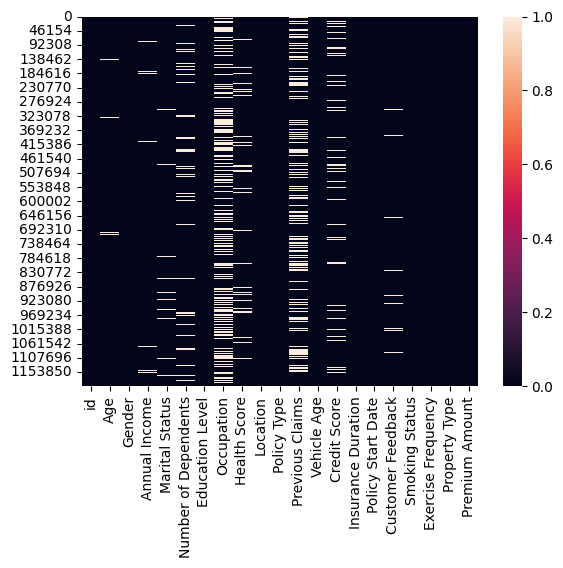

In [4]:
sns.heatmap(df_train.isna())

In [5]:
df_train['Health Score'].dropna().astype(int).nunique()

57

In [6]:
# Percentages of missing rows per column
df_train.isna().mean().mul(100)

id                       0.000000
Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64

<Figure size 1000x600 with 0 Axes>

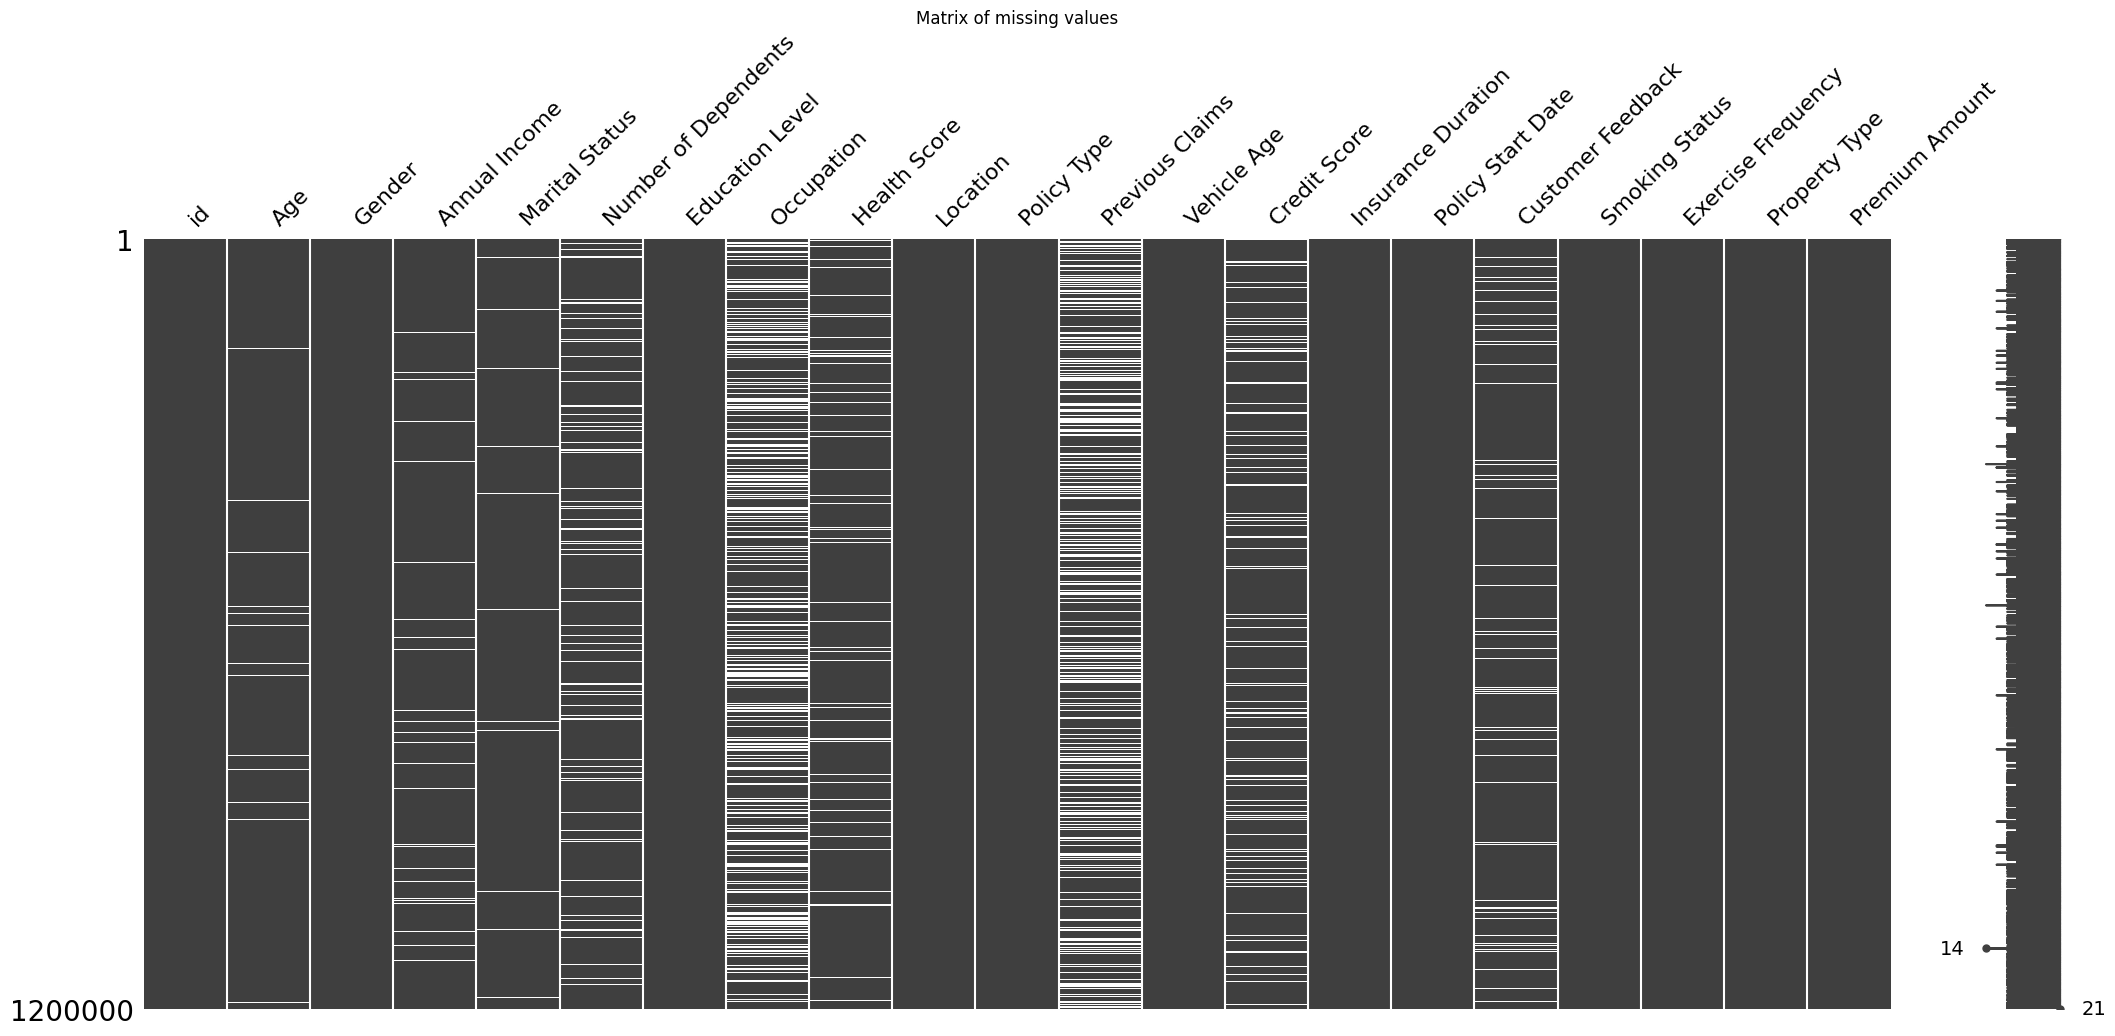

In [7]:
# Creating a matrix of missing data
plt.figure(figsize=(10,6))
msno.matrix(df_train)
plt.title('Matrix of missing values')
plt.show()

In [8]:
df_train['Health Score'].value_counts()

Health Score
19.927241    128
25.907650    124
19.869701    119
22.955402    104
27.845006    103
            ... 
34.912272      1
23.564147      1
23.054968      1
7.078633       1
11.483482      1
Name: count, Length: 532657, dtype: int64

/tmp/ipykernel_950/882930106.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Cat', order=data['Cat'].value_counts().index, **kwargs, palette = 'pastel')
/tmp/ipykernel_950/882930106.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Cat', order=data['Cat'].value_counts().index, **kwargs, palette = 'pastel')
/tmp/ipykernel_950/882930106.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Cat', order=data['Cat'].value_counts().index, **kwargs, palette = 'pastel')
/tmp/ipykernel_950/882930

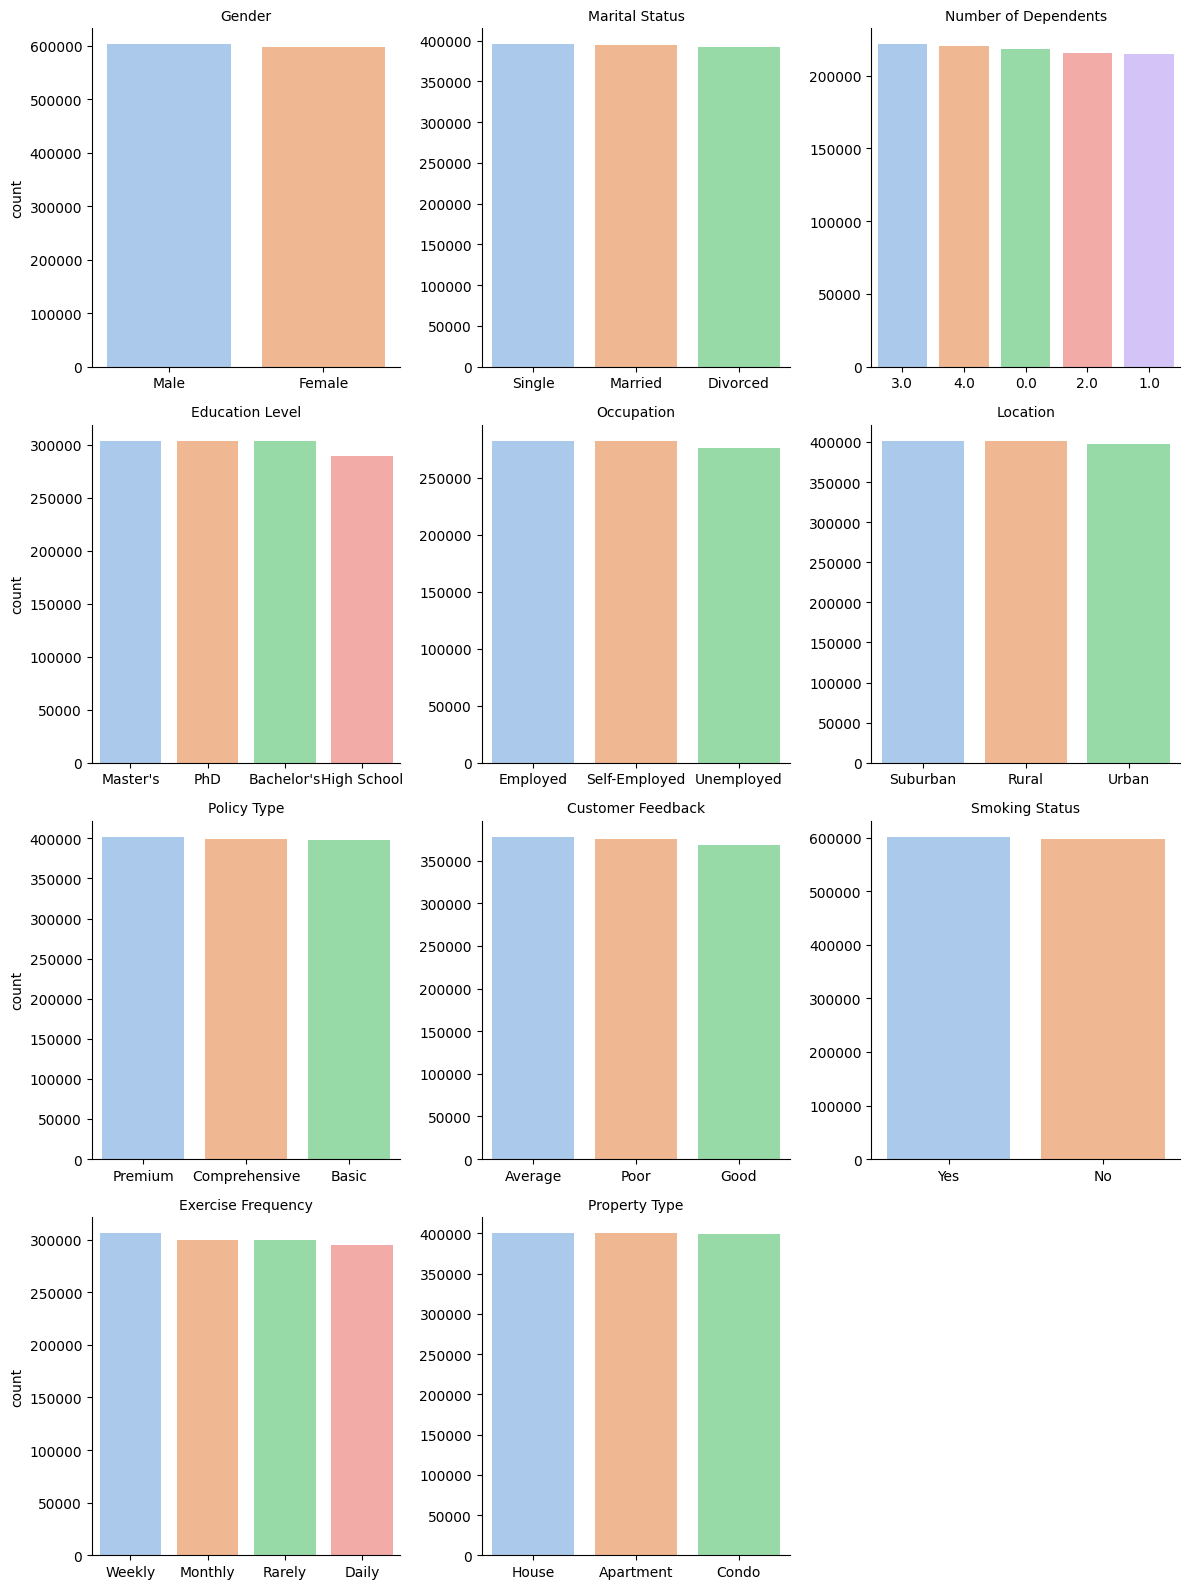

In [9]:
numerical_vars = ['Age', 'Annual Income', 'Health Score',
                  'Previous Claims', 'Vehicle Age', 'Credit Score',
                  'Insurance Duration', 'Premium Amount']



# Melting the dataframe
melted_cats = df_train.drop(['id', 'Policy Start Date']+numerical_vars,
                            axis =1).melt(var_name='Feat', value_name='Cat')

fg = sns.FacetGrid(melted_cats, col='Feat', col_wrap=3, height=4, sharex=False, sharey=False)


# Mapping bar plots to a grid
def plot_feature(data, **kwargs):
    feature = data['Feat'].iloc[0]  # Get the current feature being plotted
    sns.countplot(data=data, x='Cat', order=data['Cat'].value_counts().index, **kwargs, palette = 'pastel')

fg.map_dataframe(plot_feature)

# Plot adjustments
fg.set_axis_labels(x_var='', y_var='count')
fg.set_titles("{col_name}")
fg.tight_layout()
plt.show()

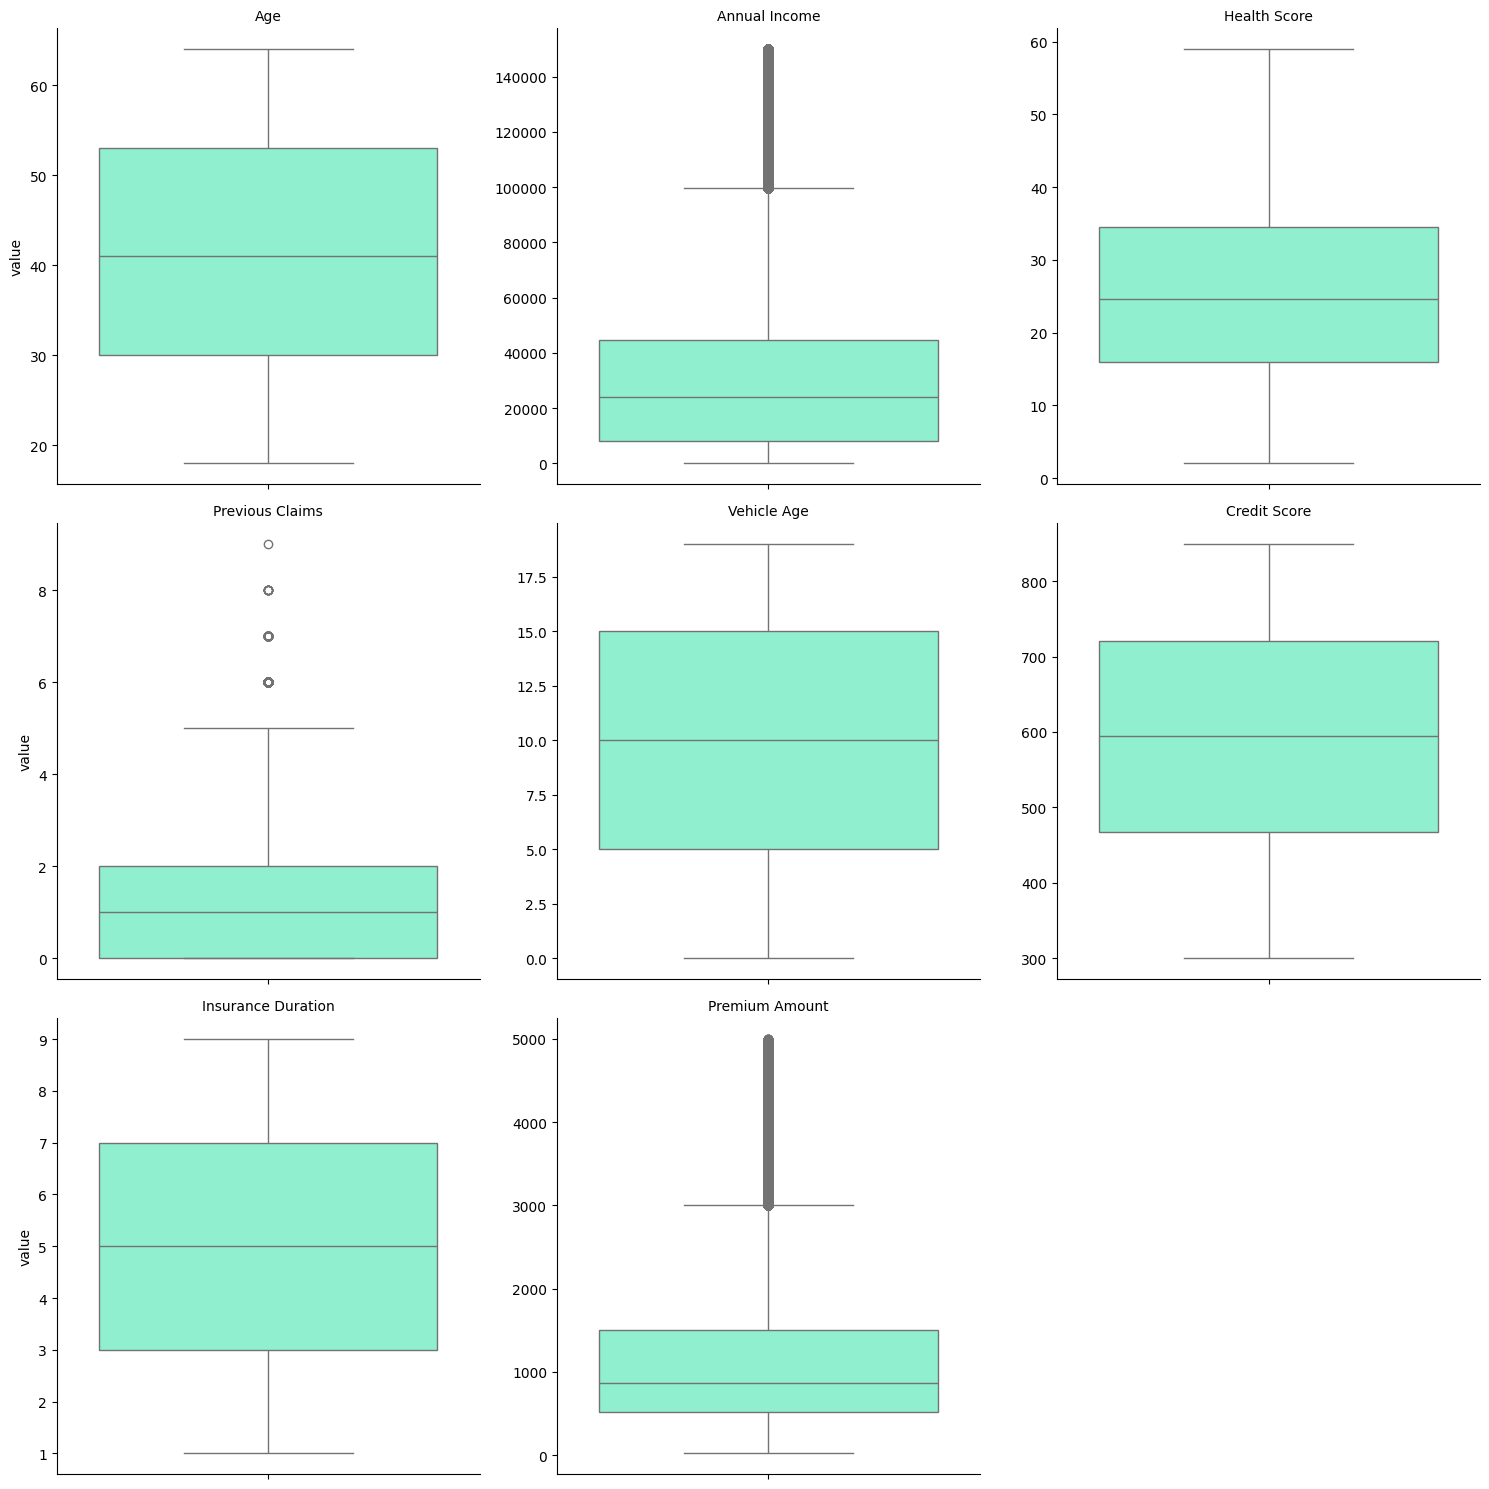

In [10]:
melted_nums = df_train[numerical_vars].melt(var_name='Feat',
                                            value_name='Value')

# Create a FacetGrid for box plots
fg = sns.FacetGrid(melted_nums, col='Feat', col_wrap=3, height=5, sharey=False)

# Mapping box plots to the grid
fg.map_dataframe(sns.boxplot, y='Value', color='aquamarine')

# Plot adjustments
fg.set_axis_labels(x_var='', y_var='value')
fg.set_titles("{col_name}")
fg.tight_layout()
plt.show()

Text(0.5, 1.0, 'Premium Amount based on its duration and number of claims')

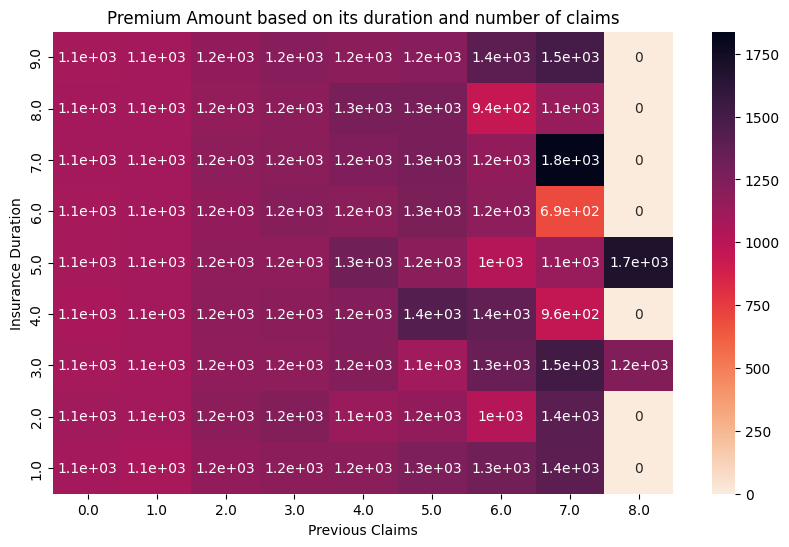

In [11]:
work_ps = df_train.dropna().pivot_table(
    index='Insurance Duration',  
    columns= 'Previous Claims',  
    values='Premium Amount',
    aggfunc='mean', 
    fill_value=0
)


plt.figure(figsize=(10, 6))
sns.heatmap(work_ps, annot=True, cmap="rocket_r", cbar=True).invert_yaxis()
plt.title('Premium Amount based on its duration and number of claims')